<a href="https://colab.research.google.com/github/tancik/IllusionDiffusion/blob/main/IllusionDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Illusion Diffusion
By [Matt Tancik](https://www.matthewtancik.com/)

Based on fast.ai [diffusion notebooks](https://github.com/fastai/diffusion-nbs).

![ChessUrl](https://user-images.githubusercontent.com/3310961/218217058-4c3daad4-1e3f-4f14-8c50-782d40c70501.gif "chess")



In [ ]:
# @title #Install requirements
# !pip install -q --upgrade transformers diffusers ftfy mediapy

from base64 import b64encode

import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

import numpy as np
import mediapy as mp
import cv2

from pathlib import Path
from torch import autocast
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login("")

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {torch_device}")
print(f"Device name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")


In [2]:
# @title #Load Models
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae", torch_dtype=torch.float16)

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet", torch_dtype=torch.float16)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


0


/tmp/ipykernel_1884874/3371216033.py:42: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

,

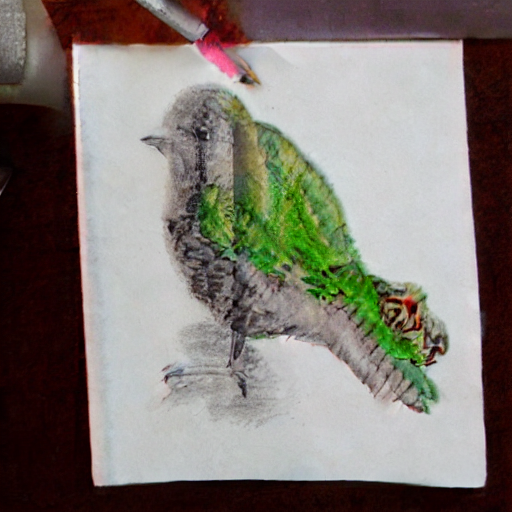
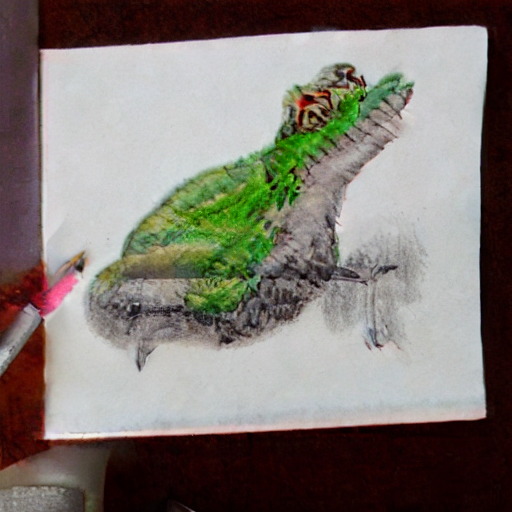

In [9]:
#@title #Generate Images
first_prompt = "A cartoon drawing of a frog" #@param {type:"string"}
second_prompt = "A cartoon drawing of a bird" #@param {type:"string"}
rotation_deg = 90 #@param [90, 180]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
#@markdown More steps improves quality but takes longer.
num_inference_steps = 500 #@param {type:"integer"}
guidance_scale = 7.5 #@param {type:"slider", min:2, max:15, step:0.5}
seed = 42 #@param {type:"integer"}
generator = torch.manual_seed(seed)   
batch_size = 1
rotate = int(rotation_deg) // 90

# for seed in [0,1,2,3 ,4,5,6,7]:
# 0,3,5    
for seed in [0]:
    print(seed)
    generator = torch.manual_seed(seed)

    # Prep text 
    text_input = tokenizer([first_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    text_input_2 = tokenizer([second_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
        test_embeddings_2 = text_encoder(text_input_2.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    text_embeddings_2 = torch.cat([uncond_embeddings, test_embeddings_2])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.half()
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            
            
            if i % 2 == 0:
                latents = torch.rot90(latents, rotate, [2, 3])
                latent_model_input = torch.cat([latents] * 2)
            else:
                latent_model_input = torch.cat([latents] * 2)
            
            sigma = scheduler.sigmas[i]
            # Scale the latents (preconditioning):
            # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            with torch.no_grad():
                if i % 2 == 0:
                    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
                else:
                    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings_2).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            
            if i % 2 == 0:
                noise_pred = torch.rot90(noise_pred, -rotate, [2, 3])
                latents = torch.rot90(latents, -rotate, [2, 3])

            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, t, latents).prev_sample

    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    # Display
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).round().astype("uint8")[0, ...]

    mp.show_images([image, np.rot90(image, rotate, (0, 1))])

In [10]:
# @title #Generate Animation
num_frames = 300 # @param

degrees = 90 * rotate

def rotate_image(image, angle):
    rows, cols, _ = image.shape
    rot_mat = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    result = cv2.warpAffine(image, rot_mat, (cols,rows))
    return result

def easeInOutQuint(x):
    if x < 0.5:
        return 4 * x**3
    else:
        return 1 - (-2 * x + 2)**3 / 2

ts = np.concatenate([np.zeros(num_frames//4), 
                     np.linspace(0, 1, num_frames//4),
                     np.ones(num_frames//4),
                     np.linspace(1, 0, num_frames//4)])
ts = [easeInOutQuint(x) for x in ts]

frames = [rotate_image(image, t * degrees) for t in ts]
mp.show_video(frames)